In [2]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from datetime import datetime

In [4]:
# Paso 1: Cargar y analizar datos
# Leer el archivo de Excel
data = pd.read_excel('C:/Users/gonza/OneDrive/Desktop/machine learning/Retail_Invoices.xlsx')


In [6]:
# Vista inicial de los datos
print(data.head())
print(data.info())
print(data.describe())


  InvoiceNo InvoiceDate  CustomerID  Quantity  price_total  StockCode
0    536365  2010-12-01       17850        40       139.12          7
1    536366  2010-12-01       17850        12        22.20          2
2    536367  2010-12-01       13047        83       278.73         12
3    536368  2010-12-01       13047        15        70.05          4
4    536369  2010-12-01       13047         3        17.85          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB

In [12]:
# 1. Identificar valores anómalos en 'Quantity' y 'price_total'
print("Cantidad de registros con Quantity negativa:", (data['Quantity'] < 0).sum())
print("Cantidad de registros con price_total negativa:", (data['price_total'] < 0).sum())


Cantidad de registros con Quantity negativa: 3654
Cantidad de registros con price_total negativa: 3654


In [14]:
# 2. Filtrar datos con valores negativos (si representan devoluciones)
data_cleaned = data[(data['Quantity'] > 0) & (data['price_total'] > 0)]


In [16]:
# 3. Confirmar limpieza
print("Datos después de la limpieza:")
print(data_cleaned.describe())


Datos después de la limpieza:
                         InvoiceDate    CustomerID      Quantity  \
count                          18532  18532.000000  18532.000000   
mean   2011-07-01 03:39:44.718324736  15266.378211    278.899363   
min              2010-12-01 00:00:00  12346.000000      1.000000   
25%              2011-03-30 00:00:00  13776.250000     74.000000   
50%              2011-07-12 00:00:00  15178.500000    155.000000   
75%              2011-10-12 00:00:00  16779.000000    291.000000   
max              2011-12-09 00:00:00  18287.000000  80995.000000   
std                              NaN   1734.116296    972.734580   

         price_total     StockCode  
count   18532.000000  18532.000000  
mean      480.865956     21.471886  
min         0.380000      1.000000  
25%       158.037500      6.000000  
50%       303.040000     15.000000  
75%       471.840000     28.000000  
max    168469.600000    542.000000  
std      1678.195579     24.920241  


In [18]:
# Verificar los valores restantes
print(f"Registros eliminados: {len(data) - len(data_cleaned)}")

Registros eliminados: 3658


In [20]:
# Paso 2: Crear variables RFM
# Definir fecha de referencia
reference_date = data['InvoiceDate'].max()

In [22]:
# Calcular Recency, Frequency y Monetary a nivel de cliente
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency: Días desde la última compra
    'InvoiceNo': 'count',  # Frequency: Cantidad de transacciones
    'price_total': 'sum'  # Monetary: Gasto total
}).reset_index()

In [24]:
# Renombrar columnas para claridad
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [26]:
# Ver primeras filas del RFM
print("Variables RFM calculadas:")
print(rfm.head())

Variables RFM calculadas:
   CustomerID  Recency  Frequency  Monetary
0       12346      325          2      0.00
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       18          1   1757.55
4       12350      310          1    334.40


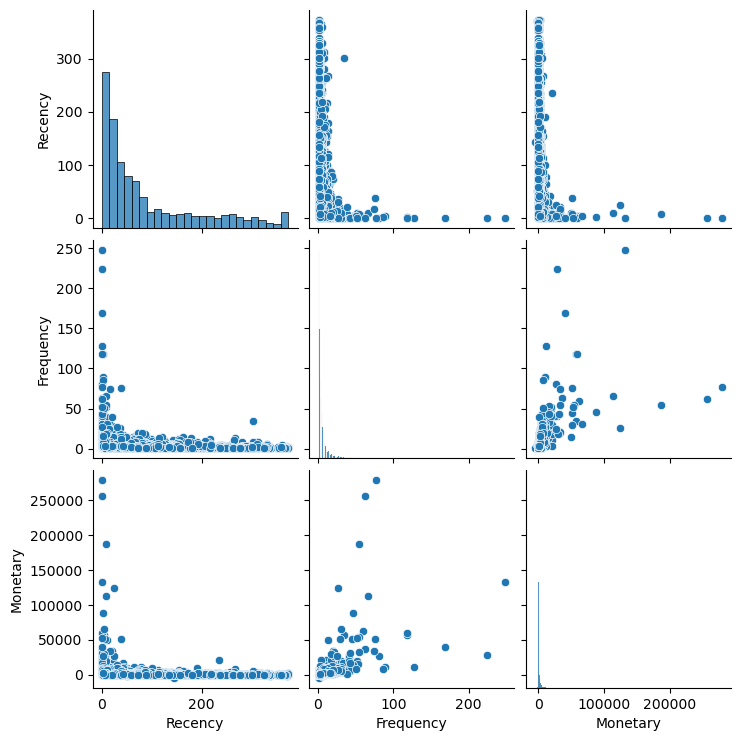

In [28]:
# Visualizar distribuciones de R, F y M
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary']])
plt.show()


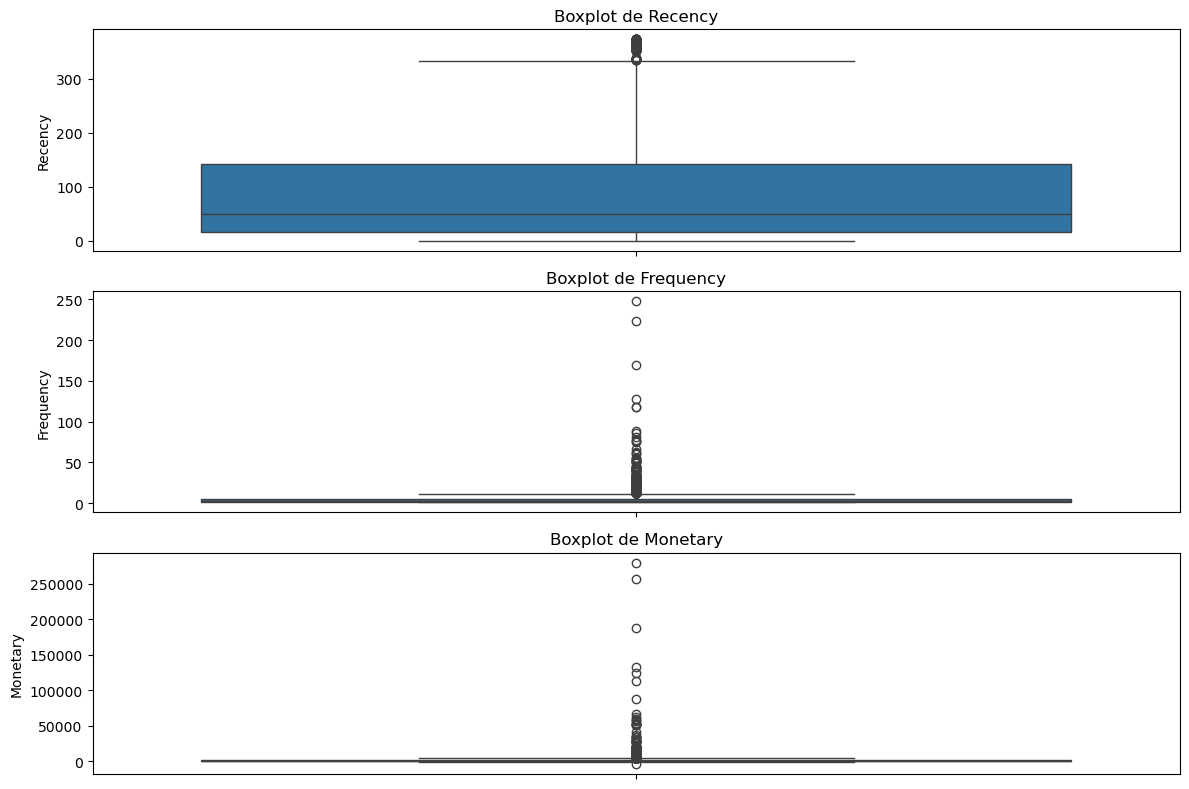

In [30]:
# Boxplots para identificar outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(3, 1, i + 1)
    sns.boxplot(rfm[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()


In [32]:
# Escalado de datos para clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [34]:
# Método del codo para determinar número óptimo de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

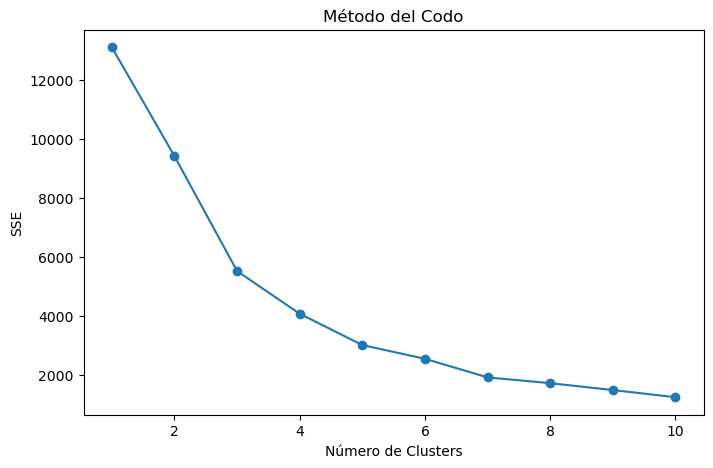

In [36]:
# Visualizar SSE para determinar número de clusters
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.title('Método del Codo')
plt.show()

In [38]:
# Aplicar K-means con el número óptimo de clusters 
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


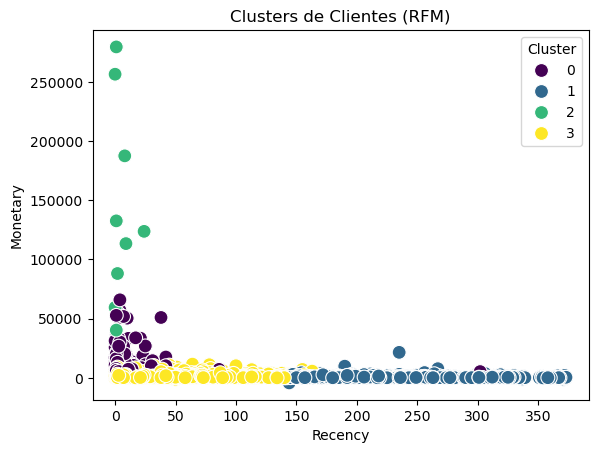

In [40]:
# Visualizar los clusters en un scatterplot
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100)
plt.title('Clusters de Clientes (RFM)')
plt.show()

In [42]:
#  Evaluación y descripción de clusters
# Calcular Silhouette Score
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score para K-means: {silhouette_avg:.2f}")


Silhouette Score para K-means: 0.61


In [44]:
# Describir los clusters
cluster_summary = rfm.groupby('Cluster').mean()
print("Resumen por cluster:")
print(cluster_summary)

Resumen por cluster:
           CustomerID     Recency   Frequency       Monetary
Cluster                                                     
0        15184.871134   10.216495   28.510309   12168.264691
1        15354.337674  248.653953    1.802791     455.132596
2        15289.090909    4.363636  109.909091  124312.306364
3        15287.914942   42.386805    4.369987    1320.413827


In [50]:
# SSE se calcula en el paso de clustering
print(f"SSE final: {kmeans.inertia_}")

SSE final: 4081.896097033868


In [54]:
#Código para calcular distancias entre centroides:
from scipy.spatial.distance import cdist

centroids = kmeans.cluster_centers_
distances = cdist(centroids, centroids)
print("Distancias entre centroides:")
print(distances)

Distancias entre centroides:
[[ 0.          3.97054871 16.2000329   2.91318899]
 [ 3.97054871  0.         19.15831002  2.06796636]
 [16.2000329  19.15831002  0.         18.75808707]
 [ 2.91318899  2.06796636 18.75808707  0.        ]]


In [56]:
# Resumir los valores promedio de cada cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

In [58]:
# Agregar nombres descriptivos basados en los valores promedio
cluster_summary['Descripcion'] = [
    'Clientes leales: compran con frecuencia y gastan mucho',
    'Clientes recientes: compraron hace poco pero no tan frecuentemente',
    'Clientes inactivos: hace mucho que no compran',
    'Clientes ocasionales: compras esporádicas y de bajo monto'
]  # Ajustar según el análisis
print(cluster_summary)

   Cluster     Recency   Frequency       Monetary  \
0        0   10.216495   28.510309   12168.264691   
1        1  248.653953    1.802791     455.132596   
2        2    4.363636  109.909091  124312.306364   
3        3   42.386805    4.369987    1320.413827   

                                         Descripcion  
0  Clientes leales: compran con frecuencia y gast...  
1  Clientes recientes: compraron hace poco pero n...  
2      Clientes inactivos: hace mucho que no compran  
3  Clientes ocasionales: compras esporádicas y de...  


In [ ]:
# Interpretación:
Cluster 0 - Clientes leales: Estos clientes son valiosos, ya que compran con alta frecuencia y generan altos ingresos. Se les pueden ofrecer descuentos VIP o programas de fidelidad.
Cluster 1 - Clientes inactivos: Necesitan ser reactivados con campañas de marketing como descuentos o promociones específicas.
Cluster 2 - Clientes recientes: Han comenzado a comprar recientemente; pueden ser incentivados para convertirse en clientes leales.
Cluster 3 - Clientes ocasionales: Compran de manera esporádica; campañas dirigidas pueden aumentar su frecuencia.